In [2]:
#Qiskit includes
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute
from qiskit import Aer
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise.errors.readout_error import *
from qiskit.circuit import Instruction
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)
#Other python tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.lines as mlines

In [3]:
np.random.seed(3)

N_data = 10000
sigma = 3
true_data = np.clip(np.random.randn(N_data)*sigma,-10.,10.)
true_data_int = [round(x) for x in true_data]
randnoise = np.random.uniform(0.,1.,N_data)
reco_data_int = []
for i in range(len(true_data_int)):
    reco_data_int+=[true_data_int[i]]
    if (true_data_int[i]==-10 and randnoise[i]<0.25):
        reco_data_int[i]+=1
    elif (true_data_int[i]==10 and randnoise[i]<0.25):
        reco_data_int[i]-=1
    elif (abs(true_data_int[i]) < 10 and randnoise[i]<0.25):
        reco_data_int[i]-=1
    elif (abs(true_data_int[i]) < 10 and randnoise[i]<0.5):
        reco_data_int[i]+=1 
        pass
    pass

Text(0, 0.5, 'Counts')

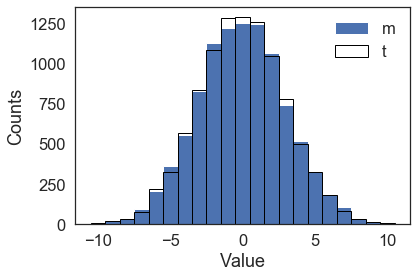

In [258]:
m,b,_ = plt.hist(reco_data_int,bins=np.linspace(-10.5,10.5,22),label='m')
t,b,_ = plt.hist(true_data_int,bins=np.linspace(-10.5,10.5,22),facecolor="none",edgecolor='black',label="t")
plt.legend(frameon=False)
plt.xlabel('Value')
plt.ylabel('Counts')

In [5]:
#Let's assume we know R exactly.
R = []
for i in range(len(m)):
    R += [[]]
    for j in range(len(t)):
        if (i==0):
            if (j==0):
                R[i] += [0.75]
            elif (j==1):
                R[i] += [0.25]
            else:
                R[i] += [0.]
        elif (i==len(t)-1):
            if (j==len(t)-1):
                R[i] += [0.75]
            elif (j==len(t)-2):
                R[i] += [0.25]
            else:
                R[i] += [0.]
        else:
            if (abs(i-j)==0):
                R[i] += [0.5]
            elif (abs(i-j)==1):
                R[i] += [0.25]
            else:
                R[i] += [0.] 

Unfolding Methods

In [216]:
def MatrixInversion(ymes,Rin):
    #Rin is a matrix where the first coordinate is the measured value and the second coordinate is the true value.
    return np.ravel(np.matmul(np.linalg.inv(np.matrix(Rin)),ymes))

def fun(x,ymes,Rin):
    mat_dot_x = np.ravel(np.matmul(Rin,x))
    return sum((ymes - mat_dot_x)**2)

def Ignis(ymes,Rin):
    #Rin is a matrix where the first coordinate is the measured value and the second coordinate is the true value.
    #This is copied from https://github.com/Qiskit/qiskit-ignis/blob/master/qiskit/ignis/mitigation/measurement/filters.py
    x0 = np.random.rand(len(ymes))
    x0 = x0 / sum(x0)
    nshots = sum(ymes)
    cons = ({'type': 'eq', 'fun': lambda x: nshots - sum(x)})
    bnds = tuple((0, nshots) for x in x0)
    res = minimize(fun, x0, method='SLSQP',constraints=cons, bounds=bnds, tol=1e-6, args=(ymes,Rin))
    return res.x

def IBU(ymes,t0,Rin,n):
    #This is the iterative Bayesian unfolding method.
    #Rin is a matrix where the first coordinate is the measured value and the second coordinate is the true value.
    #n is the number of iterations.
    
    tn = t0
    for q in range(n):
        out = []
        for j in range(len(t0)):
            mynum = 0.
            for i in range(len(ymes)):
                myden = 0.
                for k in range(len(t0)):
                    myden+=Rin[i][k]*tn[k]
                    pass
                mynum+=Rin[i][j]*tn[j]*ymes[i]/myden
                pass
            out+=[mynum]
        tn = out
        pass
    '''
    tn = t0
    for i in range(n):
        Rjitni = [np.array(Rin[:][i])*tn[i] for i in range(len(tn))]
        Pm_given_t = Rjitni / np.matmul(Rin,tn)
        tn = np.dot(Pm_given_t,ymes)
        pass
    '''
    return tn

In [262]:
that_matrix = MatrixInversion(m,R)
that_ignis = Ignis(m,R)
that_IBU = IBU(m,np.ones(len(m)),R,10)

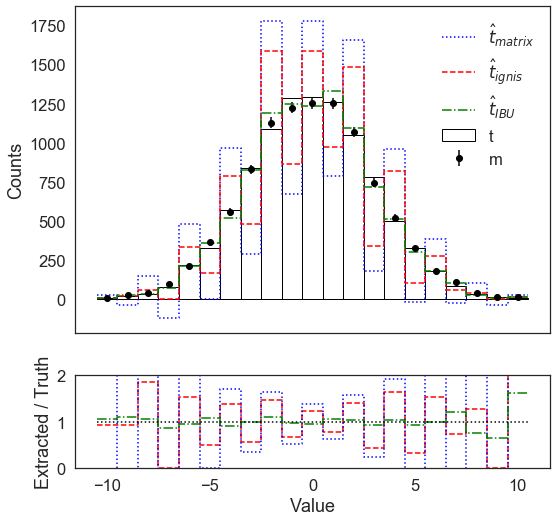

In [263]:
def myre(x):
    return np.concatenate([[x[0]],x])

f = plt.figure(figsize=(8.5, 8.5))
gs = GridSpec(2, 1, width_ratios=[1], height_ratios=[3.5, 1])
ax1 = plt.subplot(gs[0])
ax1.set_xticklabels( () )

mybincenters = np.linspace(-10.5,10.5,22)
plt.errorbar(0.5*(b[1:]+b[:-1]),m,yerr=np.sqrt(m),label='m',marker='o',linestyle='none',color='black')
t,b,_ = plt.hist(true_data_int,bins=np.linspace(-10.5,10.5,22),facecolor="none",edgecolor='black',label="t")
plt.step(mybincenters,myre(that_matrix),color='blue',linestyle=':',label=r"$\hat{t}_{matrix}$")
plt.step(mybincenters,myre(that_ignis),color='red',linestyle='--',label=r"$\hat{t}_{ignis}$")
plt.step(mybincenters,myre(that_IBU),color='green',linestyle='-.',label=r"$\hat{t}_{IBU}$")
plt.legend(frameon=False)
plt.ylabel('Counts')

ax2 = plt.subplot(gs[1])
ratio_ignis = np.zeros(len(m))
ratio_matrix = np.zeros(len(m))
ratio_IBU = np.zeros(len(m))
for i in range(len(m)):
    ratio_matrix[i]=1.
    ratio_ignis[i]=1.
    if (t[i] > 0):
        ratio_matrix[i] = that_matrix[i]/t[i]
        ratio_ignis[i] = that_ignis[i]/t[i]
        ratio_IBU[i] = that_IBU[i]/t[i]
        pass
    pass
sns.set_style("white")
plt.ylim([0.,2.])
plt.step(mybincenters,myre(ratio_ignis),color='red',linestyle='--')
plt.step(mybincenters,myre(ratio_matrix),color='blue',linestyle=":")
plt.step(mybincenters,myre(ratio_IBU),color='green',linestyle="-.")
plt.ylabel('Extracted / Truth')
plt.xlabel('Value')
xx2 = [1.,1.]
plt.plot([mybincenters[0],mybincenters[len(mybincenters)-1]],xx2,color='black',linestyle=':')
plt.savefig("plots/fig1.pdf",bbox_inches='tight')

Let's explore the response matrices from the Tokyo IBM Q machine

In [9]:
def mybin(input,q,r=1):
  if (r==0):
    return bin(input).split('b')[1].zfill(q) 
  else:
    return bin(input).split('b')[1].zfill(q)[::-1]  

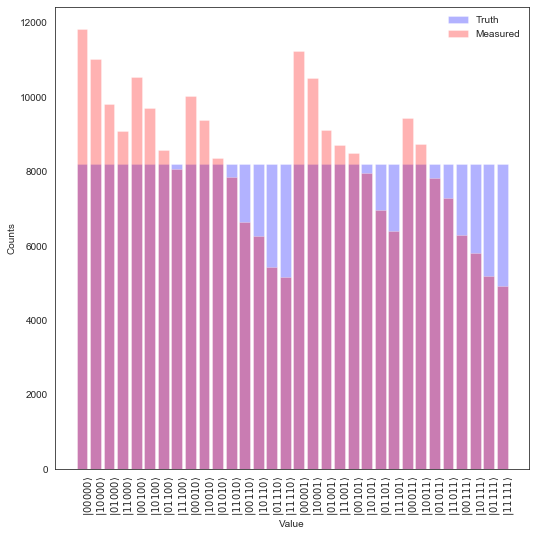

In [10]:
nqbits = 5
bin_convert = {}
for i in range(2**nqbits):
  bin_convert[bin(i).split('b')[1].zfill(nqbits)]=i
  pass

measured = np.zeros(2**nqbits)
truth = np.zeros(2**nqbits)
response = np.zeros((2**nqbits,2**nqbits))

for i in range(2**nqbits):
  myfile = open("tokyodata/output_gLR0_Tokyo_Unfold.dat")
  for line in myfile:
    if "Unfold_1" in line:
      myline = line.split("}")[i].split(",")
      for j in myline:
        if ":" not in j:
          continue
        outbin = 0
        counts = 0
        if "{" in j:
          outbin = int(bin_convert[j.split("{")[len(j.split("{"))-1].split(":")[0].split("'")[1]])
          counts = int(j.split("{")[len(j.split("{"))-1].split(":")[1])
        else:
          outbin = int(bin_convert[j.split(":")[0].split("'")[1]])
          counts = int(j.split(":")[1])
          pass
        truth[i] += counts
        measured[outbin] += counts
        response[outbin,i] += counts
        pass
      pass
    pass
  pass

sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
plt.bar(range(2**nqbits),truth,alpha=0.3,color='b',label='Truth')
plt.bar(range(2**nqbits),measured,alpha=0.3,color='r',label='Measured')
xvals = []
xlabs = []
for i in range(2**nqbits):
  xvals+=[i+0.5]
  xlabs+=[r'$|'+mybin(i,nqbits)+r'\rangle$']
  pass
plt.xticks(xvals,xlabs,rotation='vertical',size=10)
plt.ylabel("Counts")
plt.xlabel("Value")
plt.legend(frameon=False,loc='upper right')

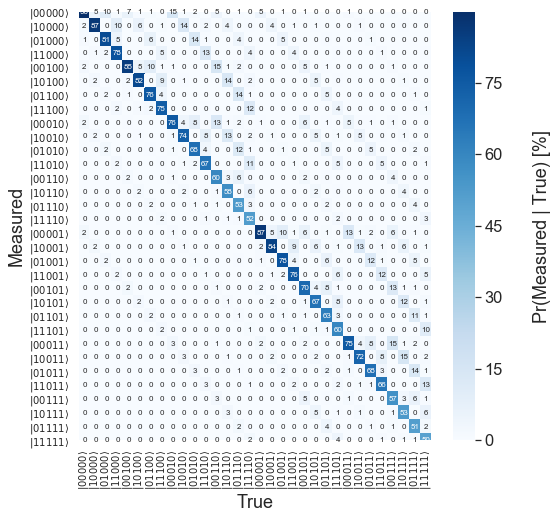

In [12]:
response_normalized = np.zeros((2**nqbits,2**nqbits))
response_normalized_reversed = np.zeros((2**nqbits,2**nqbits))
response_labels = np.zeros((2**nqbits,2**nqbits))
for i in range(2**nqbits):
  mysum = 0.
  for j in range(2**nqbits):
    mysum+=response[j,i]
    pass
  for j in range(2**nqbits):
    response_labels[j][i] = '0'
    if (mysum > 0):
      response_normalized[j,i] = 100.*response[j,i]/mysum
      response_normalized_reversed[i,j] = response_normalized[j,i]
      response_labels[j][i] = '%1.0f' % (response_normalized[j,i])
      pass
    pass
  pass

f = plt.figure(figsize=(8.5, 8.5))
sns.set(font_scale=1.5)
ax = sns.heatmap(response_normalized,annot=response_labels,annot_kws={"size": 8},cmap="Blues")
ax.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax.collections[0].colorbar
cbar.set_label('Pr(Measured | True) [%]', labelpad=30)
plt.xticks(xvals,xlabs,rotation='vertical',fontsize=10)
plt.yticks(xvals,xlabs,rotation='horizontal',fontsize=10)
plt.xlabel('True',fontsize=18)
plt.ylabel('Measured',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)
plt.savefig("plots/fig4.pdf",bbox_inches='tight')

In [13]:
def fun0(x,Rin):
    myR = []
    for i in range(2**nqbits):
        myR += [[]]
        for j in range(2**nqbits):
            meas = mybin(i,nqbits)
            true = mybin(j,nqbits)
            myp = 1.
            for k in range(len(meas)):
                if (meas[k]=='0' and true[k]=='1'):
                    myp *= x[0]
                elif (meas[k]=='1' and true[k]=='0'):
                    myp *= x[1]
                elif (meas[k]=='0' and true[k]=='0'):
                    myp *= (1.-x[0])
                else:
                    myp *= (1.-x[1])
                    pass
                pass
            myR[i]+=[myp]
            pass
        pass
    return np.sum((Rin/100. - myR)**2)

In [14]:
def fun1(x,Rin):
    x = np.reshape(x,[nqbits,2])
    myR = []
    for i in range(2**nqbits):
        myR += [[]]
        for j in range(2**nqbits):
            meas = mybin(i,nqbits)
            true = mybin(j,nqbits)
            myp = 1.
            for k in range(len(meas)):
                if (meas[k]=='0' and true[k]=='1'):
                    myp *= x[k][0]
                elif (meas[k]=='1' and true[k]=='0'):
                    myp *= x[k][1]
                elif (meas[k]=='0' and true[k]=='0'):
                    myp *= (1.-x[k][0])
                else:
                    myp *= (1.-x[k][1])
                    pass
                pass
            myR[i]+=[myp]
            pass
        pass
    return np.sum((Rin/100. - myR)**2)

In [ ]:
x0 = [0.5,0.5]
bnds = tuple((0, 1.) for x in x0)
res = minimize(fun0, x0, method='SLSQP',bounds=bnds, tol=1e-6, args=(response_normalized_reversed))
universal = res.x

x0 = []
for i in range(nqbits):
    x0+=[[0.5,0.5]]
    pass
x0 = np.array(x0)
x0 = np.reshape(x0,[2*len(x0),1])
bnds = tuple((0, 1.) for x in x0)
res = minimize(fun1, x0, method='SLSQP',bounds=bnds, tol=1e-6, args=(response_normalized_reversed))
perqubit = res.x

In [16]:
#We can also check from the matrix itself what the transition probabilities look like when all the other qubits are fixed.

one_to_zero_x = []
one_to_zero_y = []
zero_to_one_x = []
zero_to_one_y = []
for k in range(nqbits):
    mydict = {}
    for i in range(2**nqbits):
        for j in range(2**nqbits):
            meas = mybin(i,nqbits)
            true = mybin(j,nqbits)
            issame = True
            mylab = true[:k]+true[k+1:]
            if mylab not in mydict:
                mydict[mylab]={}
                pass
            if (true[:k]+true[k+1:] == meas[:k]+meas[k+1:]):
                if (meas[k]=='0' and true[k]=='0'):
                    mydict[mylab][0,0] = response_normalized[i,j]
                elif (meas[k]=='0' and true[k]=='1'):
                    mydict[mylab][1,0] = response_normalized[i,j]
                elif (meas[k]=='1' and true[k]=='0'):
                    mydict[mylab][0,1] = response_normalized[i,j]
                else:
                    mydict[mylab][1,1] = response_normalized[i,j]
                pass
            pass
        pass
    for val in mydict:
        one_to_zero_x+=[k]
        one_to_zero_y+=[mydict[val][1,0]/(mydict[val][1,0]+mydict[val][1,1])]
        zero_to_one_x+=[k]
        zero_to_one_y+=[mydict[val][0,1]/(mydict[val][0,0]+mydict[val][0,1])]
        pass

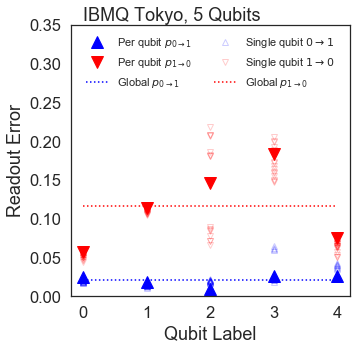

In [17]:
sns.set_style("white")
f = plt.figure(figsize=(5,5))
plt.plot(range(nqbits),[perqubit[2*i] for i in range(nqbits)],marker='^',linestyle='none',color='blue',label=r'Per qubit $p_{0\rightarrow 1}$',markersize=12)
plt.plot(range(nqbits),[perqubit[2*i+1] for i in range(nqbits)],marker='v',linestyle='none',color='red',label=r'Per qubit $p_{1\rightarrow 0}$',markersize=12)
plt.plot(range(nqbits),np.ones(nqbits)*universal[0],color='blue',linestyle=":",label=r'Global $p_{0\rightarrow 1}$')
plt.plot(zero_to_one_x,zero_to_one_y,linestyle='none',color='blue',marker='^', mfc='none',alpha=0.2,label=r'Single qubit $0\rightarrow 1$')
plt.plot(one_to_zero_x,one_to_zero_y,linestyle='none',color='red',marker='v', mfc='none',alpha=0.2,label=r'Single qubit $1\rightarrow 0$')
plt.plot(range(nqbits),np.ones(nqbits)*universal[1],color='red',linestyle=":",label=r'Global $p_{1\rightarrow 0}$')
plt.xlabel('Qubit Label')
plt.ylabel('Readout Error')
plt.legend(frameon=False,loc='upper center',fontsize=11,ncol=2)
plt.ylim([0,0.35])
plt.text(0., 0.355, "IBMQ Tokyo, 5 Qubits", fontsize=18)
plt.savefig("plots/fig5.pdf",bbox_inches='tight')

In [18]:
print("Relative spread in filled markers for 0 -> 1:",np.std([perqubit[2*i] for i in range(nqbits)])/np.mean([perqubit[2*i] for i in range(nqbits)]))
print("Relative spread in filled markers for 1 -> 0:",np.std([perqubit[2*i+1] for i in range(nqbits)])/np.mean([perqubit[2*i+1] for i in range(nqbits)]))

Relative spread in filled markers for 0 -> 1: 0.29849781269309067
Relative spread in filled markers for 1 -> 0: 0.3989394525749185


Now, let's show the pathological example for a QIS simulation.

In [19]:
def SHO_groundstate(x):
    return np.exp(-x**2/2)

<ErrorbarContainer object of 3 artists>

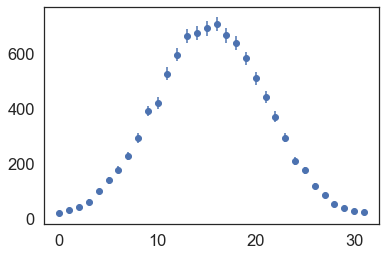

In [20]:
#Here is how you could setup an entangled Gaussian.  This is not needed for this example (more in the next cells), but it is useful and thus shown here.
nq = 5

qr = QuantumRegister(nq, 'qr')
cr = ClassicalRegister(nq, 'cr')
circ = QuantumCircuit(qr, cr)

qrs = []
for i in range(nq):
    qrs+=[qr[i]]
    pass

desired_vector = []
for i in range(2**nq):
    desired_vector += [SHO_groundstate(2.*(-2**(nq-1)+i+0.5)/2**(nq-1))]
    pass
desired_vector /= np.sqrt(np.sum([x**2 for x in desired_vector]))

circ.initialize(desired_vector, qrs)
circ.measure(qr, cr)
simulator = Aer.get_backend('qasm_simulator')
result = execute(circ, simulator,shots=10000).result()
mycounts = result.get_counts(circ)
           
xvals = []
yvals = []
for j in range(2**nq):
    xvals+=[j]
    yvals+=[mycounts[mybin(j,nq)[::-1]]]
    
sns.set_style("white")
plt.errorbar(xvals,yvals,yerr=np.sqrt(yvals),linestyle='none',marker='o')

In [38]:
nqubits = 4
ntest = 1000000
ntrain = 1000000

#This sets up some useful arrays and functions for later.
mymapping = {}
mymapping_inverse = {}
for i in range(2**nqubits):
    mymapping[i] = bin(i).split('b')[1]
    mymapping_inverse[bin(i).split('b')[1]] = i
    pass

nqubitarray = []
for i in range(nqubits):
    nqubitarray+=[i]
    pass

def mybin(input,q,r=1):
    if (r==0):
        return bin(input).split('b')[1].zfill(q) 
    else:
        return bin(input).split('b')[1].zfill(q)[::-1]  

xvals = []
xlabs = []
xlabs0 = []
for i in range(2**nqubits):
    xvals+=[i]
    xlabs+=[r'$|'+mybin(i,nqubits)+r'\rangle$']
    xlabs0+['']
    pass

In [39]:
#Let's make the noise model

epsilon = 0.25

mynoise = []
first_row = [1.-epsilon,epsilon]
last_row = []
for i in range(2,2**nqubits):
    first_row+=[0.]
    last_row+=[0.]
    pass
last_row += [epsilon,1.-epsilon]
mynoise+=[first_row]
for i in range(1,2**nqubits-1):
    middle_rows = []
    for j in range(2**nqubits):
        if (j==i-1 or j==i+1):
            middle_rows+=[epsilon]
        elif (j==i):
            middle_rows+=[1.-2*epsilon]
        else:
            middle_rows+=[0.]
            pass
        pass
    mynoise+=[middle_rows]
    pass
mynoise+=[last_row]
c = ReadoutError(mynoise)
noise_model = noise.NoiseModel()
noise_model.add_readout_error(c,nqubitarray)

In [78]:
#This is a special measure function that allows us to simultaneously measure multiple qubits at the same time.
measure2 = Instruction("measure", nqubits, nqubits, [])

#Test distribution is a Gaussian, the ground state of a SHO.  Note that we could prepare
#the initial state to be in a superposition of qubits so that every measurement follows
#a Gaussian.  However, in that case, we don't know the true distribution in the finite
#statistics limit.  For studying readout errors in isolation in simulation, we don't need
#the qubits to be entangled.

mymean = 1. #1 means the Gaussian is centered.
mystd = 3.
myvals = mystd*np.random.randn(ntest)+2**(nqubits-1)*mymean
#myvals = np.random.uniform(0,2**(nqubits),ntest)

for i in range(len(myvals)):
    myvals[i] = int(myvals[i])
    if (myvals[i] < 0):
        myvals[i]=0
        pass
    if (myvals[i] > 2**(nqubits)-1):
        myvals[i] = 2**(nqubits)-1
        pass
scult_vals = {}
for i in range(2**nqubits):
    scult_vals[i] = len([x for x in myvals if x==i])
    pass

simulator = Aer.get_backend('qasm_simulator')

many_counts = []
many_counts_sculpt = []
many_counts_sculpt_corrected = []

#First, let's compute what qiskit-ignis would do
qr_calib = QuantumRegister(nqubits)
meas_cals, state_labels = complete_meas_cal(qubit_list=nqubitarray, qr=qr_calib)

#Calibration circuit - ignis's built in one doesn't work for multi-qubit readout errors.
meas_cals_mine = []
for i in range(2**nqubits):
    binnumber_initial = mybin(i,nqubits)
    qr = QuantumRegister(nqubits, 'qr')
    cr = ClassicalRegister(nqubits, 'cr')
    circ = QuantumCircuit(qr, cr)
    for j in range(nqubits):
        if (binnumber_initial[j]=='1'):
            circ.x(qr[j])
            pass
        pass
    pass
    circ.name='cal_'+binnumber_initial[::-1] #Their convention is backwards of mine.
    circ.name=circ.name
    circ.append(measure2, nqubitarray, nqubitarray)
    meas_cals_mine+=[circ]
    pass

#These are our custom calibration circuits.
job = execute(meas_cals_mine, backend=simulator, shots=int(ntrain/(2**nqubits)), noise_model=noise_model)
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter

#Let's first quickly process these
many_counts = []
for i in range(2**nqubits):
    binnumber_initial = mybin(i,nqubits)
    counts = cal_results.get_counts(meas_cals_mine[i])
    many_counts+=[counts]
    pass

#Let's make our own matrix based on cal_results.
measured_cal = np.zeros(2**nqubits)
truth_cal = np.zeros(2**nqubits)
response_cal = np.zeros((2**nqubits,2**nqubits))
for j in range(len(many_counts)):
    counts = many_counts[j]
    for i in range(2**nqubits):
        binnumber_initial = mybin(i,nqubits,0)
        if (binnumber_initial in counts):
            measured_cal[i]+=counts[binnumber_initial]
            truth_cal[j]+=counts[binnumber_initial]
            response_cal[i,j]+=counts[binnumber_initial]
            pass
        pass
    pass
response_normalized_cal = np.zeros((2**nqubits,2**nqubits))
for i in range(len(truth_cal)):
    for j in range(len(truth_cal)):
        response_normalized_cal[i,j]=response_cal[i,j]/truth_cal[j]
        pass
    pass

#Okay, now for the "test" aka the measurement.
for i in range(2**nqubits):
    binnumber_initial = mybin(i,nqubits)
    
    #Calibration circuit
    qr = QuantumRegister(nqubits, 'qr')
    cr = ClassicalRegister(nqubits, 'cr')
    circ = QuantumCircuit(qr, cr)
    for j in range(nqubits):
        if (binnumber_initial[j]=='1'):
            circ.x(qr[j])
            pass
        pass
    pass
    circ.append(measure2, nqubitarray, nqubitarray)
    counts_sculpt = {}

    if (scult_vals[i] > 0):
        result2 = execute(circ, simulator,noise_model=noise_model,shots=scult_vals[i]).result()
        counts_sculpt = result2.get_counts(circ)
        pass
    many_counts_sculpt+=[counts_sculpt]
    pass

measured_test = np.zeros(2**nqubits)
truth_test = np.zeros(2**nqubits)
response_test = np.zeros((2**nqubits,2**nqubits))
for j in range(len(many_counts_sculpt)):
    counts = many_counts_sculpt[j]
    for i in range(2**nqubits):
        binnumber_initial = mybin(i,nqubits,0)
        if (binnumber_initial in counts):
            measured_test[i]+=counts[binnumber_initial]
            truth_test[j]+=counts[binnumber_initial]
            response_test[j,i]+=counts[binnumber_initial]
            pass
        pass
    pass

many_counts = {}
for i in range(2**nqubits):
    binnumber_final = mybin(i,nqubits,0)
    many_counts[binnumber_final] = 0
    for j in many_counts_sculpt:
        if binnumber_final in j:
            many_counts[binnumber_final]+=j[binnumber_final]
            pass
        pass
    pass

ignis_counts = meas_filter.apply(many_counts)

measured_test_ignis = []
for i in range(2**nqubits):
    binnumber_initial = mybin(i,nqubits)
    measured_test_ignis+=[ignis_counts[binnumber_initial[::-1]]]
    pass

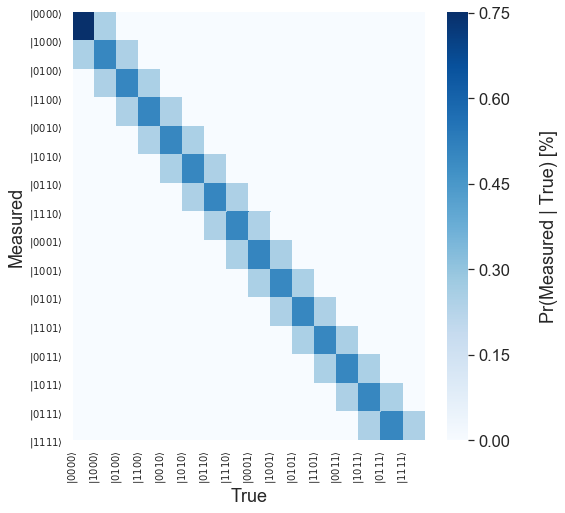

In [79]:
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
sns.set(font_scale=1.5)
ax = sns.heatmap(response_normalized_cal,annot_kws={"size": 8},cmap="Blues")
ax.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax.collections[0].colorbar
cbar.set_label('Pr(Measured | True) [%]', labelpad=30)
plt.xticks(xvals,xlabs,rotation='vertical',fontsize=10)
plt.yticks(xvals,xlabs,rotation='horizontal',fontsize=10)
plt.xlabel('True',fontsize=18)
plt.ylabel('Measured',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)
plt.savefig("plots/fig4.pdf",bbox_inches='tight')

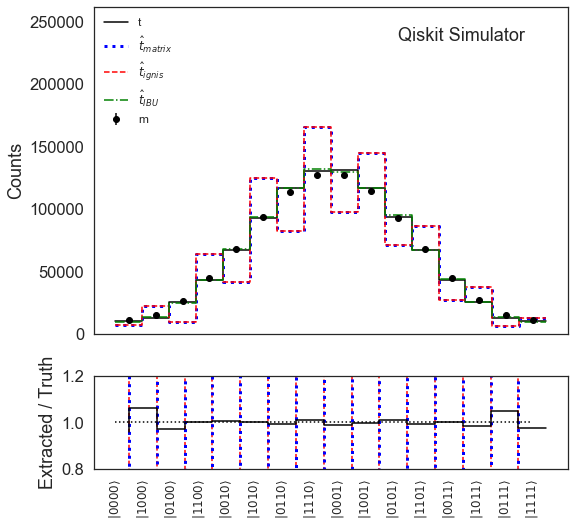

In [217]:
#Now, for the unfolding.
unfolded_Matrix = MatrixInversion(measured_test,response_normalized_cal)
unfolded_IBU = IBU(measured_test,truth_cal,response_normalized_cal,10)

bincenters = np.array(xvals)+0.5
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
gs = GridSpec(2, 1, width_ratios=[1], height_ratios=[3.5, 1])
ax1 = plt.subplot(gs[0])
ax1.set_xticklabels( () )

def myre(x):
    return np.concatenate([[x[0]],x])

#mybincenters = np.linspace(-0.5,31.5,33)
mybincenters = np.linspace(-0.5,15.5,17)
plt.step(mybincenters,myre(truth_test),color='black',label=r"t")
plt.errorbar(0.5*(mybincenters[1:]+mybincenters[:-1]),measured_test,yerr=np.sqrt(measured_test),label='m',marker='o',linestyle='none',color='black')
plt.step(mybincenters,myre(unfolded_Matrix),color='blue',linestyle=':',label=r"$\hat{t}_{matrix}$",linewidth=3.0)
plt.step(mybincenters,myre(measured_test_ignis),color='red',linestyle='--',label=r"$\hat{t}_{ignis}$")
plt.step(mybincenters,myre(unfolded_IBU),color='green',linestyle='-.',label=r"$\hat{t}_{IBU}$")

_=plt.xticks(xvals,xlabs0,rotation='vertical',fontsize=10)
plt.ylabel('Counts')
plt.ylim([0,2.*max(truth_test)])
plt.legend(loc='upper left',fontsize=12,frameon=False)
_=plt.text(10., max(truth_test)*1.8, "Qiskit Simulator", fontsize=18)

ax2 = plt.subplot(gs[1])
ratio_ignis2 = np.zeros(2**nqubits)
ratio_ignis = np.zeros(2**nqubits)
ratio_matrix = np.zeros(2**nqubits)
ratio_unfold = np.zeros(2**nqubits)
for i in range(len(ratio_unfold)):
    ratio_unfold[i]=1.
    ratio_matrix[i]=1.
    ratio_ignis[i]=1.
    ratio_ignis2[i]=1.
    if (truth_test[i] > 0):
        ratio_unfold[i] = unfolded_IBU[i]/truth_test[i]
        ratio_matrix[i] = unfolded_Matrix[i]/truth_test[i]
        ratio_ignis[i] = measured_test_ignis[i]/truth_test[i]
        pass
    pass

plt.ylim([0.8,1.2])
plt.step(bincenters,ratio_ignis,color='red',linestyle="--")
plt.step(bincenters,ratio_matrix,color='blue',linestyle=":",linewidth=3.0)
plt.step(bincenters,ratio_unfold,color='black')
plt.ylabel('Extracted / Truth')
xx2 = [1.,1.]
plt.plot([xvals[0],xvals[len(xvals)-1]],xx2,color='black',linestyle=':')
_=plt.xticks(xvals,xlabs,rotation='vertical',fontsize=12)
plt.savefig("plots/fig4.pdf",bbox_inches='tight')

#Save this random number !!

Now, let's use the realistic response matrix.

In [209]:
nqubits_r = 5
ntest_r = 1000000
ntrain_r = 1000000

#This sets up some useful arrays and functions for later.
mymapping_r = {}
mymapping_inverse_r = {}
for i in range(2**nqubits_r):
    mymapping_r[i] = bin(i).split('b')[1]
    mymapping_inverse_r[bin(i).split('b')[1]] = i
    pass

nqubitarray_r = []
for i in range(nqubits_r):
    nqubitarray_r+=[i]
    pass 

xvals_r = []
xlabs_r = []
xlabs0_r = []
for i in range(2**nqubits_r):
    xvals_r+=[i]
    xlabs_r+=[r'$|'+mybin(i,nqubits_r)+r'\rangle$']
    xlabs0_r+['']
    pass

In [210]:
#We can directly use the Tokyo response matrix.
mynoise_r = []
for i in range(2**nqubits_r):
    hold = []
    for j in range(2**nqubits_r):
        #if (i==j):
        #    hold+=[1.]
        #else:
        #    hold+=[0.]
        hold+=[response_normalized[j][i]/100.]
        pass
    mynoise_r+=[hold]
    pass
c_r = ReadoutError(mynoise_r)
noise_model_r = noise.NoiseModel()
noise_model_r.add_readout_error(c_r,nqubitarray_r)

In [211]:
#This is a special measure function that allows us to simultaneously measure multiple qubits at the same time.
measure2_r = Instruction("measure", nqubits_r, nqubits_r, [])

#Test distribution is a Gaussian, the ground state of a SHO.  Note that we could prepare
#the initial state to be in a superposition of qubits so that every measurement follows
#a Gaussian.  However, in that case, we don't know the true distribution in the finite
#statistics limit.  For studying readout errors in isolation in simulation, we don't need
#the qubits to be entangled.

mymean_r = 1. #1 means the Gaussian is centered.
mystd_r = 3.5
myvals_r = mystd_r*np.random.randn(ntest_r)+2**(nqubits_r-1)*mymean_r
#myvals = np.random.uniform(0,2**(nqubits),ntest)

for i in range(len(myvals_r)):
    myvals_r[i] = int(myvals_r[i])
    if (myvals_r[i] < 0):
        myvals_r[i]=0
        pass
    if (myvals_r[i] > 2**(nqubits_r)-1):
        myvals_r[i] = 2**(nqubits_r)-1
        pass
scult_vals_r = {}
for i in range(2**nqubits_r):
    scult_vals_r[i] = len([x for x in myvals_r if x==i])
    pass

simulator_r = Aer.get_backend('qasm_simulator')

many_counts_r = []
many_counts_sculpt_r = []
many_counts_sculpt_corrected_r = []

#First, let's compute what qiskit-ignis would do
qr_calib_r = QuantumRegister(nqubits_r)
meas_cals_r, state_labels_r = complete_meas_cal(qubit_list=nqubitarray_r, qr=qr_calib_r)

#Calibration circuit - ignis's built in one doesn't work for multi-qubit readout errors.
meas_cals_mine_r = []
for i in range(2**nqubits_r):
    binnumber_initial = mybin(i,nqubits_r)
    qr_r = QuantumRegister(nqubits_r, 'qr')
    cr_r = ClassicalRegister(nqubits_r, 'cr')
    circ_r = QuantumCircuit(qr_r, cr_r)
    for j in range(nqubits_r):
        if (binnumber_initial[j]=='1'):
            circ_r.x(qr_r[j])
            pass
        pass
    pass
    circ_r.name='cal_'+binnumber_initial[::-1] #Their convention is backwards of mine.
    circ_r.name=circ_r.name
    circ_r.append(measure2_r, nqubitarray_r, nqubitarray_r)
    meas_cals_mine_r+=[circ_r]
    pass

#These are our custom calibration circuits.
job_r = execute(meas_cals_mine_r, backend=simulator_r, shots=int(ntrain_r/(2**nqubits_r)), noise_model=noise_model_r)
cal_results_r = job_r.result()
meas_fitter_r = CompleteMeasFitter(cal_results_r, state_labels_r)
meas_filter_r = meas_fitter_r.filter

#Let's first quickly process these
many_counts_r = []
for i in range(2**nqubits_r):
    binnumber_initial = mybin(i,nqubits_r)
    counts_r = cal_results_r.get_counts(meas_cals_mine_r[i])
    many_counts_r+=[counts_r]
    pass

#Let's make our own matrix based on cal_results.
measured_cal_r = np.zeros(2**nqubits_r)
truth_cal_r = np.zeros(2**nqubits_r)
response_cal_r = np.zeros((2**nqubits_r,2**nqubits_r))
for j in range(len(many_counts_r)):
    counts = many_counts_r[j]
    for i in range(2**nqubits_r):
        binnumber_initial = mybin(i,nqubits_r,0)
        if (binnumber_initial in counts):
            measured_cal_r[i]+=counts[binnumber_initial]
            truth_cal_r[j]+=counts[binnumber_initial]
            response_cal_r[i,j]+=counts[binnumber_initial]
            pass
        pass
    pass
response_normalized_cal_r = np.zeros((2**nqubits_r,2**nqubits_r))
for i in range(len(truth_cal_r)):
    for j in range(len(truth_cal_r)):
        response_normalized_cal_r[i,j]=response_cal_r[i,j]/truth_cal_r[j]
        pass
    pass

#Okay, now for the "test" aka the measurement.
for i in range(2**nqubits_r):
    binnumber_initial = mybin(i,nqubits_r)
    
    #Calibration circuit
    qr_r = QuantumRegister(nqubits_r, 'qr')
    cr_r = ClassicalRegister(nqubits_r, 'cr')
    circ_r = QuantumCircuit(qr_r, cr_r)
    for j in range(nqubits_r):
        if (binnumber_initial[j]=='1'):
            circ_r.x(qr_r[j])
            pass
        pass
    pass
    circ_r.append(measure2_r, nqubitarray_r, nqubitarray_r)
    counts_sculpt_r = {}

    if (scult_vals_r[i] > 0):
        result2_r = execute(circ_r, simulator_r,noise_model=noise_model_r,shots=scult_vals_r[i]).result()
        counts_sculpt_r = result2_r.get_counts(circ_r)
        pass
    many_counts_sculpt_r+=[counts_sculpt_r]
    pass

measured_test_r = np.zeros(2**nqubits_r)
truth_test_r = np.zeros(2**nqubits_r)
response_test_r = np.zeros((2**nqubits_r,2**nqubits_r))
for j in range(len(many_counts_sculpt_r)):
    counts = many_counts_sculpt_r[j]
    for i in range(2**nqubits_r):
        binnumber_initial = mybin(i,nqubits_r,0)
        if (binnumber_initial in counts):
            measured_test_r[i]+=counts[binnumber_initial]
            truth_test_r[j]+=counts[binnumber_initial]
            response_test_r[j,i]+=counts[binnumber_initial]
            pass
        pass
    pass

many_counts_r = {}
for i in range(2**nqubits_r):
    binnumber_final_r = mybin(i,nqubits_r,0)
    many_counts_r[binnumber_final_r] = 0
    for j in many_counts_sculpt_r:
        if binnumber_final_r in j:
            many_counts_r[binnumber_final_r]+=j[binnumber_final_r]
            pass
        pass
    pass

ignis_counts_r = meas_filter_r.apply(many_counts_r)

measured_test_ignis_r = []
for i in range(2**nqubits_r):
    binnumber_initial_r = mybin(i,nqubits_r)
    if (binnumber_initial_r[::-1] in ignis_counts_r):
        measured_test_ignis_r+=[ignis_counts_r[binnumber_initial_r[::-1]]]
    else:
        measured_test_ignis_r+=[0.]
    pass

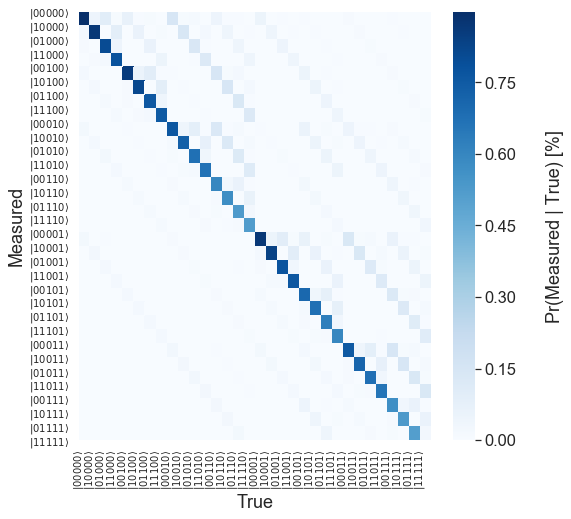

In [212]:
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
sns.set(font_scale=1.5)
ax = sns.heatmap(response_normalized_cal_r,annot_kws={"size": 8},cmap="Blues")
ax.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax.collections[0].colorbar
cbar.set_label('Pr(Measured | True) [%]', labelpad=30)
plt.xticks(xvals_r,xlabs_r,rotation='vertical',fontsize=10)
plt.yticks(xvals_r,xlabs_r,rotation='horizontal',fontsize=10)
plt.xlabel('True',fontsize=18)
plt.ylabel('Measured',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)
plt.savefig("plots/fig4_r.pdf",bbox_inches='tight')

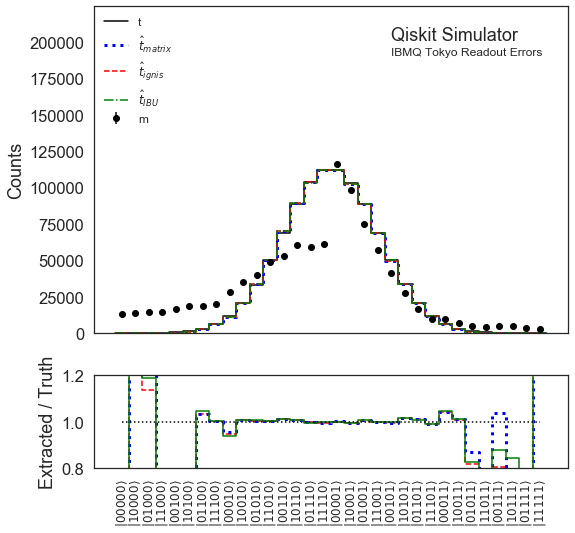

In [219]:
#Now, for the unfolding.
unfolded_Matrix_r = MatrixInversion(measured_test_r,response_normalized_cal_r)
unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,1000)

bincenters_r = np.array(xvals_r)+0.5
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
gs = GridSpec(2, 1, width_ratios=[1], height_ratios=[3.5, 1])
ax1 = plt.subplot(gs[0])
ax1.set_xticklabels( () )

mybincenters = np.linspace(-0.5,31.5,33)
#mybincenters = np.linspace(-0.5,15.5,17)
plt.step(mybincenters,myre(truth_test_r),color='black',label=r"t")
plt.errorbar(0.5*(mybincenters[1:]+mybincenters[:-1]),measured_test_r,yerr=np.sqrt(measured_test_r),label='m',marker='o',linestyle='none',color='black')
plt.step(mybincenters,myre(unfolded_Matrix_r),color='blue',linestyle=':',label=r"$\hat{t}_{matrix}$",linewidth=3.0)
plt.step(mybincenters,myre(measured_test_ignis_r),color='red',linestyle='--',label=r"$\hat{t}_{ignis}$")
plt.step(mybincenters,myre(unfolded_IBU_r),color='green',linestyle='-.',label=r"$\hat{t}_{IBU}$")

_=plt.xticks(xvals_r,xlabs0_r,rotation='vertical',fontsize=10)
plt.ylabel('Counts')
plt.ylim([0,2.*max(truth_test_r)])
plt.legend(loc='upper left',fontsize=12,frameon=False)
_=plt.text(20., max(truth_test_r)*1.8, "Qiskit Simulator", fontsize=18)
_=plt.text(20., max(truth_test_r)*1.7, "IBMQ Tokyo Readout Errors", fontsize=12)

ax2 = plt.subplot(gs[1])
ratio_ignis2_r = np.zeros(2**nqubits_r)
ratio_ignis_r = np.zeros(2**nqubits_r)
ratio_matrix_r = np.zeros(2**nqubits_r)
ratio_unfold_r = np.zeros(2**nqubits_r)
for i in range(len(ratio_unfold_r)):
    ratio_unfold_r[i]=1.
    ratio_matrix_r[i]=1.
    ratio_ignis_r[i]=1.
    ratio_ignis2_r[i]=1.
    if (truth_test_r[i] > 0):
        ratio_unfold_r[i] = unfolded_IBU_r[i]/truth_test_r[i]
        ratio_matrix_r[i] = unfolded_Matrix_r[i]/truth_test_r[i]
        ratio_ignis_r[i] = measured_test_ignis_r[i]/truth_test_r[i]
        pass
    pass

plt.ylim([0.8,1.2])
plt.step(mybincenters,myre(ratio_ignis_r),color='red',linestyle="--")
plt.step(mybincenters,myre(ratio_matrix_r),color='blue',linestyle=":",linewidth=3.0)
plt.step(mybincenters,myre(ratio_unfold_r),color='green')
plt.ylabel('Extracted / Truth')
xx2 = [1.,1.]
plt.plot([xvals_r[0],xvals_r[len(xvals_r)-1]],xx2,color='black',linestyle=':')
_=plt.xticks(xvals_r,xlabs_r,rotation='vertical',fontsize=12)
plt.savefig("plots/fig4_rr.pdf",bbox_inches='tight')

Now compute the pulls

In [251]:
pulls_unfold_r = []
pulls_matrix_r = []
pulls_ignis_r = []
for strap in range(1000):
    if (strap%10==0):
        print("on strap",strap)
        pass
    myvals_r = mystd_r*np.random.randn(int(ntest_r/100))+2**(nqubits_r-1)*mymean_r

    for i in range(len(myvals_r)):
        myvals_r[i] = int(myvals_r[i])
        if (myvals_r[i] < 0):
            myvals_r[i]=0
            pass
        if (myvals_r[i] > 2**(nqubits_r)-1):
            myvals_r[i] = 2**(nqubits_r)-1
            pass
    scult_vals_r = {}
    for i in range(2**nqubits_r):
        scult_vals_r[i] = len([x for x in myvals_r if x==i])
        pass

    many_counts_r = []
    many_counts_sculpt_r = []
    many_counts_sculpt_corrected_r = []

    #Okay, now for the "test" aka the measurement.
    for i in range(2**nqubits_r):
        binnumber_initial = mybin(i,nqubits_r)

        #Calibration circuit
        qr_r = QuantumRegister(nqubits_r, 'qr')
        cr_r = ClassicalRegister(nqubits_r, 'cr')
        circ_r = QuantumCircuit(qr_r, cr_r)
        for j in range(nqubits_r):
            if (binnumber_initial[j]=='1'):
                circ_r.x(qr_r[j])
                pass
            pass
        pass
        circ_r.append(measure2_r, nqubitarray_r, nqubitarray_r)
        counts_sculpt_r = {}

        if (scult_vals_r[i] > 0):
            result2_r = execute(circ_r, simulator_r,noise_model=noise_model_r,shots=scult_vals_r[i]).result()
            counts_sculpt_r = result2_r.get_counts(circ_r)
            pass
        many_counts_sculpt_r+=[counts_sculpt_r]
        pass

    measured_test_r = np.zeros(2**nqubits_r)
    truth_test_r = np.zeros(2**nqubits_r)
    response_test_r = np.zeros((2**nqubits_r,2**nqubits_r))
    for j in range(len(many_counts_sculpt_r)):
        counts = many_counts_sculpt_r[j]
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            if (binnumber_initial in counts):
                measured_test_r[i]+=counts[binnumber_initial]
                truth_test_r[j]+=counts[binnumber_initial]
                response_test_r[j,i]+=counts[binnumber_initial]
                pass
            pass
        pass

    many_counts_r = {}
    for i in range(2**nqubits_r):
        binnumber_final_r = mybin(i,nqubits_r,0)
        many_counts_r[binnumber_final_r] = 0
        for j in many_counts_sculpt_r:
            if binnumber_final_r in j:
                many_counts_r[binnumber_final_r]+=j[binnumber_final_r]
                pass
            pass
        pass

    ignis_counts_r = meas_filter_r.apply(many_counts_r)

    measured_test_ignis_r = []
    for i in range(2**nqubits_r):
        binnumber_initial_r = mybin(i,nqubits_r)
        if (binnumber_initial_r[::-1] in ignis_counts_r):
            measured_test_ignis_r+=[ignis_counts_r[binnumber_initial_r[::-1]]]
        else:
            measured_test_ignis_r+=[0.]
        pass

    unfolded_Matrix_r = MatrixInversion(measured_test_r,response_normalized_cal_r)
    unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100)
    for i in range(len(ratio_unfold_r)):
        pulls_unfold_r += [unfolded_IBU_r[i]-truth_test_r[i]]
        pulls_matrix_r += [unfolded_Matrix_r[i]-truth_test_r[i]]
        pulls_ignis_r += [measured_test_ignis_r[i]-truth_test_r[i]]
        pass
    pass

on strap 0
on strap 10
on strap 20
on strap 30
on strap 40
on strap 50
on strap 60
on strap 70
on strap 80
on strap 90
on strap 100
on strap 110
on strap 120
on strap 130
on strap 140
on strap 150
on strap 160
on strap 170
on strap 180
on strap 190
on strap 200
on strap 210
on strap 220
on strap 230
on strap 240
on strap 250
on strap 260
on strap 270
on strap 280
on strap 290
on strap 300
on strap 310
on strap 320
on strap 330
on strap 340
on strap 350
on strap 360
on strap 370
on strap 380
on strap 390
on strap 400
on strap 410
on strap 420
on strap 430
on strap 440
on strap 450
on strap 460
on strap 470
on strap 480
on strap 490
on strap 500
on strap 510
on strap 520
on strap 530
on strap 540
on strap 550
on strap 560
on strap 570
on strap 580
on strap 590
on strap 600
on strap 610
on strap 620
on strap 630
on strap 640
on strap 650
on strap 660
on strap 670
on strap 680
on strap 690
on strap 700
on strap 710
on strap 720
on strap 730
on strap 740
on strap 750
on strap 760
on strap 7

In [253]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.9.0',
 'qiskit': None,
 'qiskit-ignis': '0.1.1',
 'qiskit-aer': '0.2.3',
 'qiskit-ibmq-provider': None,
 'qiskit-aqua': None}

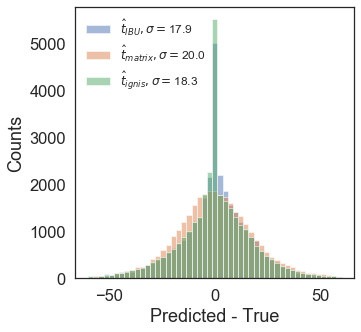

In [256]:
f = plt.figure(figsize=(5, 5))
n,b,_=plt.hist(pulls_unfold_r,bins=np.linspace(-60,60,50),alpha=0.5,label=r"$\hat{t}_{IBU}, \sigma=$"+'%s' % float('%2.3g' % np.std(pulls_unfold_r)))
plt.hist(pulls_matrix_r,bins=b,alpha=0.5,label=r"$\hat{t}_{matrix}, \sigma=$"+'%s' % float('%2.3g' % np.std(pulls_matrix_r)))
plt.hist(pulls_ignis_r,bins=b,alpha=0.5,label=r"$\hat{t}_{ignis}, \sigma=$"+'%s' % float('%2.3g' % np.std(pulls_ignis_r)))
plt.xlabel("Predicted - True")
plt.ylabel("Counts")
plt.legend(frameon=False,loc='upper left',fontsize=12)
plt.savefig("plots/fig_pull.pdf",bbox_inches='tight')